## GM - EM - SP

## 1. Gaussian Mixture Model  with EM - ALgorithm

For the Notations and the theoretical calucaltions please refer to the PDF 

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm, multivariate_normal
import matplotlib
from sklearn.cluster import KMeans
import os
from numpy import ndarray
from scipy.special import logsumexp
import itertools
from scipy.linalg import eigh
from scipy.stats import multivariate_normal as MVN


In [13]:
class Gaussian_Mixture:
    """
    Diagonal Covariance  Gaussian Mixture Model,
    using Expectation Maximization.
    -----------------------------------
    This can easily be adapted for the Full Covariance model
    ------------------------------------
    """
    
    def __init__(self, K, max_iter=500, tol=1e-4):
        self.K = K
        self.n_iter = max_iter
        self.tol = tol

    def fit(self, X):
        
        # data's dimensionality and responsibility vector
        self.n_row, self.n_col = X.shape     
        self.T = np.zeros((self.n_row, self.K))
        
        # initialize parameters
        """we can  do random init if we don't want to use K-means
        ------------------------
        chosen = np.random.choice(self.n_row, self.K, replace = False)
        self.means = X[chosen]"""
        #Kmeans initialisation
        kmeans = KMeans(n_clusters=self.K, random_state=0).fit(X)
        self.means_=kmeans.cluster_centers_
        self.P = np.full(self.K, 1 / self.K)
        
        # for np.cov, rowvar = False, 
        # indicates that the rows represents obervation
        shape = self.K, self.n_col, self.n_col
        self.covariances_ = np.full(shape, np.diag(np.var(X,axis=0)))
        
        log_likelihood = 0
        self.converged = False
        self.log_likelihood_trace = []      
        
        for i in range(self.n_iter):
            self.E_step(X)
            self.M_step(X)
            log_likelihood_new = self._compute_log_likelihood(X)
           
            if (log_likelihood - log_likelihood_new) <= self.tol:
                self.converged = True
                break
                
            log_likelihood = log_likelihood_new
            self.log_likelihood_trace.append(log_likelihood)
            
        return 
      
    def E_step(self, X):
        """
        E-step: we compute the posterior distribution of Z: T(i,j)=p(Z_i=j|X_i),
        how likely it is to see datapoint i given cluster j under the gaussian distribution  N_j 
        """
        for j in range(self.K):
            prior = self.P[j]
            normal_likelihood = multivariate_normal(self.means_[j], self.covariances_[j]).pdf(X)
            self.T[:, j] = prior * normal_likelihood
        
        # normalize over all possible clusters ( sum=1)
        self.T = self.T / self.T.sum(axis = 1, keepdims = True)
        return 
 
    def M_step(self, X):
        """M-step, update parameters P,Mean,Covariance(D)"""
        
        # total over  each cluster ( sum over the samples i of  T(i,j) in The pdf attached)
        sum_p = self.T.sum(axis = 0)
        
        # Probabilities update
        self.P = sum_p / self.n_row
        
        # means update
        #Mind the Confusion here the second .T is transpose
        self.means_ = (self.T.T@X) / sum_p.reshape(-1, 1)
        
        # covariance D
        for j in range(self.K):
            diff = (X - self.means_[j]).T
            weighted_sum = np.diag(np.diag((self.T[:, j] * diff)@ diff.T))
            self.covariances_[j] = weighted_sum / sum_p[j]
            
        return 
    
    #for Model Convergence estimation 
    
    def _compute_log_likelihood(self, X):
        """manually compute the log likelihood of the current parameter"""
        log_likelihood = 0
        for j in range(self.K):            
            weight = self.P[j]
            mean = self.means_[j]
            cov = self.covariances_[j]
            cov_inverse = np.diag(1/np.diag(cov)) # Diagonal Covariance Matrix
            term_other = np.log(2 * np.pi) + np.log(np.prod(np.diag(cov)))
            
            for x in X:
                # compute (x-mu)^T * Sigma^{-1} * (x-mu)
                diff = x - mean
                term_exponent = diff.T@cov_inverse@diff
            
                # compute loglikelihood contribution for this data point and this cluster             
                log_likelihood += -1 / 2 * (term_other + term_exponent) + np.log(weight)
            
        return log_likelihood

Just like with K-means, it is important to ask how we obtain an initial configuration of mixing weights and component parameters. In this case we'll initialize our algo's parameters by using K-means as a first step and using the mean/cov of the obtained clusters to initialize EM. Probabilities $p_k$ will be intialized uniformly.

In [116]:
def plot_contours(data,labels,features,clusters,models,compare='features',legend="True Classes"):
    """visualize the gaussian components over the data"""
    delta = 0.025
    col = ['yellow', 'indigo','orange','black']
    colors=['blue','red','green']
    subplot=-1
    if compare=='clusters':
        fig,axes=plt.subplots(len(clusters),len(features),figsize=(7*len(features),5*len(clusters)))
        if len(features)>1:
            axes=axes.reshape(len(clusters),len(features))
    elif compare=='models':
        fig,axes=plt.subplots(len(clusters),len(models),figsize=(7*len(models),5*len(clusters)))
    else:
        fig,axes=plt.subplots(3,2,figsize=(15,15))
    for i,j in features:
        if compare in ['features','clusters']:
            subplot+=1
        for row,K in enumerate(clusters) :
            for column,mode in enumerate(models) :
                model=models[mode](K)
                model.fit(data)
                #if just one model
                if compare=='features':
                    ax=axes.ravel()[subplot]
                elif compare=='clusters':
                    if len(clusters)>1:
                        ax=axes[row,subplot]
                else: 
                    ax=axes[row,column]
                for k in range(K):
                    mean = model.means_[k][[i,j]]
                    cov=model.covariances_[k][[i,j]][:,[i,j]]
                    x = np.arange(data[:,i].min()-.5, data[:,i].max()+.5, delta)
                    y = np.arange(data[:,j].min()-.5, data[:,j].max()+.5, delta)
                    X, Y = np.meshgrid(x, y)
                    position = np.empty(X.shape + (2,))
                    position[:, :, 0] = X
                    position[:, :, 1] = Y
                    Z = multivariate_normal(mean,cov).pdf(position)                        
                    ax.contour(X, Y, Z, colors = col[k])
                scatter=ax.scatter(data[:, i], data[:, j],c=labels,cmap=matplotlib.colors.ListedColormap(colors))
                
                ax.legend(*scatter.legend_elements(),title=legend)
                ax.title.set_text('model '+mode+' K='+str(K)+' Clusters, Features : '+str(i)+' , '+str(j)+' ')
    return

## Results of the Diagonal GMM Model  for all feature pairs  
Result is present in form of ellipses that represent the distribution of the probability for each datapoint to being sampled from one of the Gaussian distributions, the closer a point is to the center of the ellipis the higher the probability of it being sampled from that distribution and thus belonging to that cluster. 
Different Colors are used for the Different Ellipses, and also True classes are represented with Three different colors for the Datapoints.

we'll use the IRIS dataset available in Sklearn for testing purposes 

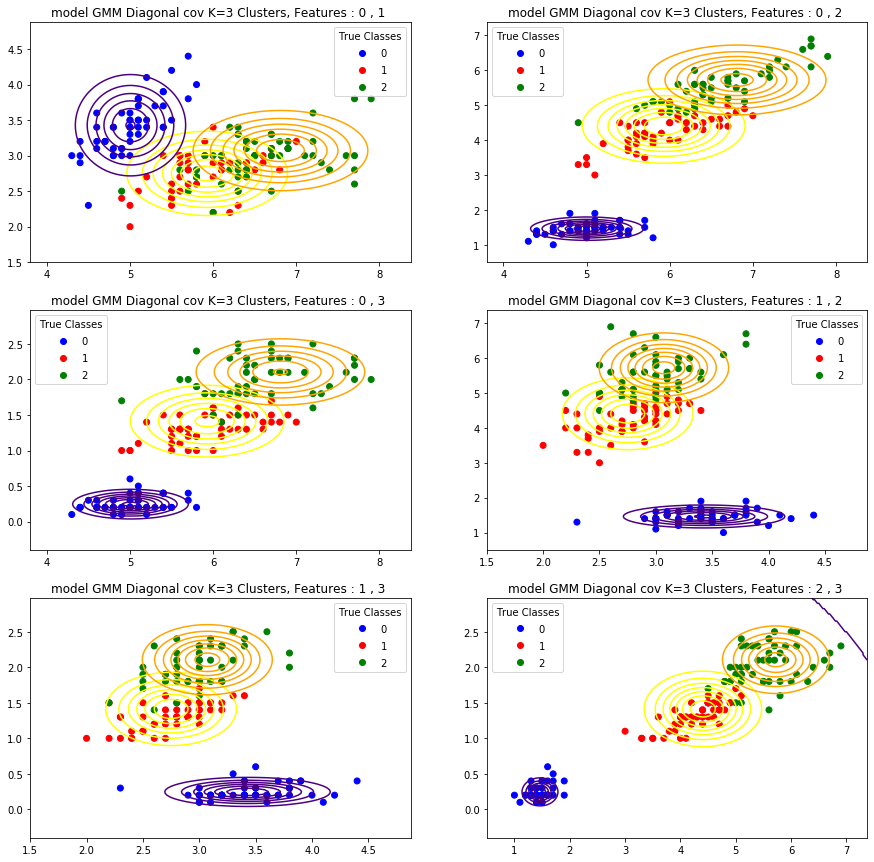

In [49]:
data,labels=datasets.load_iris(True)
models={'GMM Diagonal cov':Gaussian_Mixture}
K=[3]
features=[]
n_features=4
for i in range(n_features):
    for j in range(i+1,n_features):
        features+=[(i,j)]
#features=np.arange(0,4,1)
plot_contours(data,labels,features,K,models)

## Comparing K=2,3,4 for features pairs : (0,1)  (0,2) and (1,2)

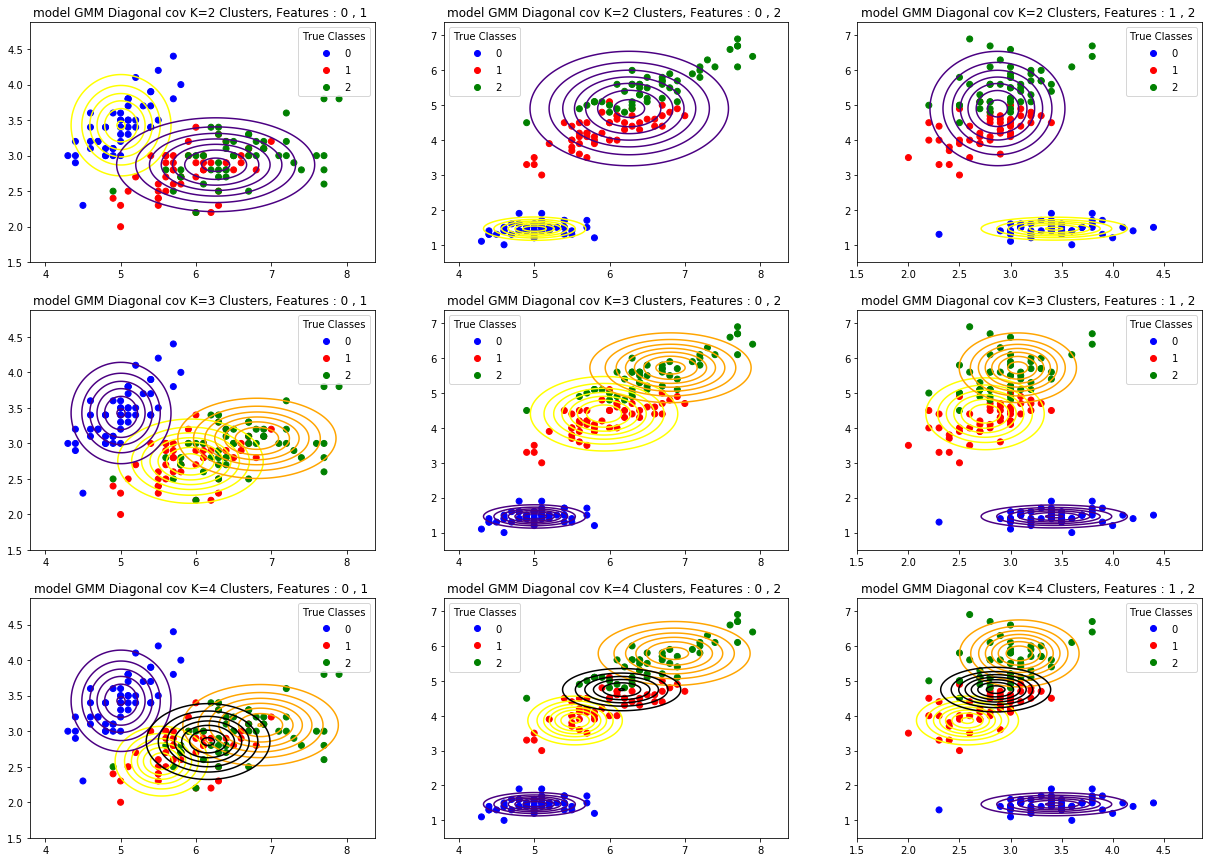

In [57]:
data,labels=datasets.load_iris(True)
models={'GMM Diagonal cov':Gaussian_Mixture}
K=[2,3,4]
features=[(0,1),(0,2),(1,2)]
plot_contours(data,labels,features,K,models,compare='clusters')

## Comparing to sklearn's Gaussian Mixture Model with full covariance Matrix
    We'll do this for features pair 0,1 and for K=2,3,4

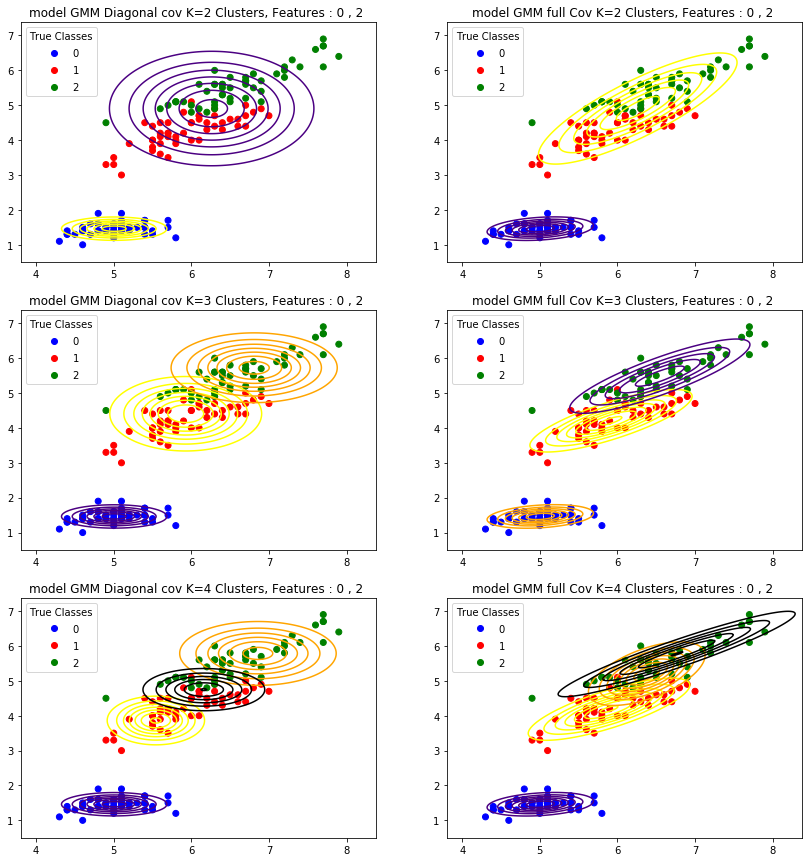

In [51]:
data,labels=datasets.load_iris(True)
models={'GMM Diagonal cov':Gaussian_Mixture,'GMM full Cov':GaussianMixture}
K=[2,3,4]
features=[(0,2)]
n_features=4
#features=np.arange(0,4,1)
plot_contours(data,labels,features,K,models,compare='models')

## Comparing To K_means
To do This we'll plot the clusters predicted by K_means and the ellipsis representing the probability Density Functions for all the features pairs

In [52]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(data)

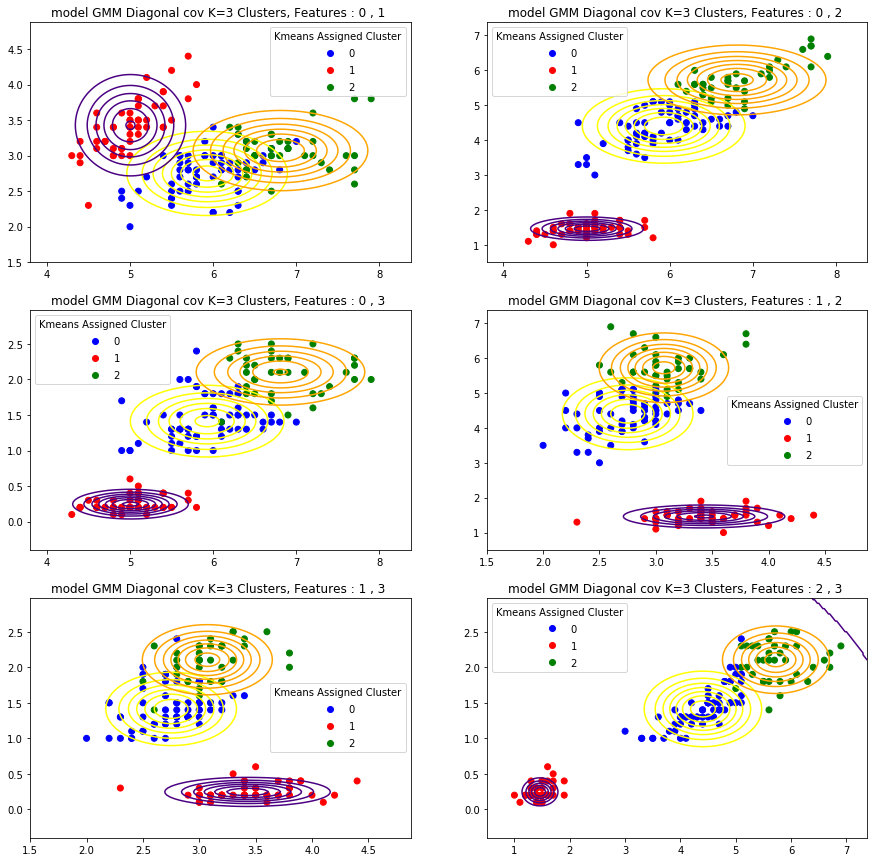

In [55]:
data,labels=datasets.load_iris(True)
models={'GMM Diagonal cov':Gaussian_Mixture}
K=[3]
features=[]
n_features=4
for i in range(n_features):
    for j in range(i+1,n_features):
        features+=[(i,j)]
#features=np.arange(0,4,1)
plot_contours(data,kmeans.labels_,features,K,models,legend='Kmeans Assigned Cluster')

## K_means vs GMM : an Example 

In [180]:
x1=np.array([i for i in np.arange(2,4.5,0.03)])
x2=np.array([i for i in np.arange(5,6,0.01)])
x=np.concatenate((x1,x2))
labels=[1 for i in x1]+[0 for i in x2]

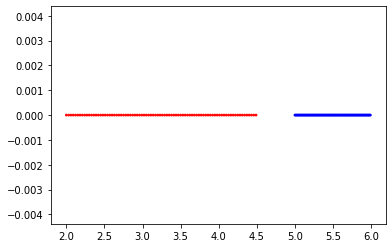

In [181]:
colors=['blue','red']
plt.scatter(x,0*x,c=labels,s=3,cmap=matplotlib.colors.ListedColormap(colors))

In [182]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(x.reshape(-1,1))

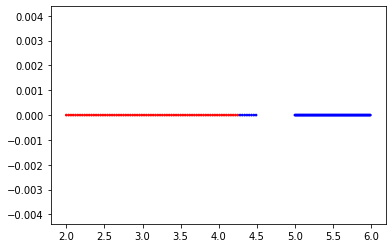

In [183]:
plt.scatter(x, x*0,c=kmeans.labels_,s=3,cmap=matplotlib.colors.ListedColormap(colors))

In [184]:
GM=Gaussian_Mixture(2)
GM.fit(x.reshape(-1,1))

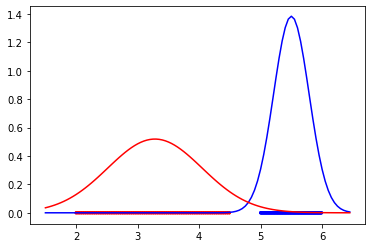

In [188]:
ax=plt.axes()
delta=0.05
for k in range(2):
    mean = GM.means_[k]
    cov=GM.covariances_[k]
    X = np.arange(x.min()-.5, x.max()+.5, delta)
    Z = multivariate_normal(mean,cov).pdf(X)                        
    ax.plot(X,Z,c=colors[k])
    scatter=plt.scatter(x,0*x,c=labels,s=5,cmap=matplotlib.colors.ListedColormap(colors))

## 2. Graphs, algorithms and Ising

Undirected Chain model:
We have:

#### $$p(x)=\frac{1}{Z}\prod_{i = 1}^n \psi_{i}(x_{i}) \prod_{i=1}^{n-1} \psi_{i,i+1}(x_{i},x_{i+1})$$

To compute marginal probabilities, we need first to compute descending and ascending messages, which are, as seen in the course:

#### * Descending messages: 
#### $$\mu_{i -> i-1}(x_{i-1}) = \sum_{x_{i}} \psi_{i-1,i}(x_{i-1},x_{i})* \psi_{i}(x_{i})* \mu_{i+1 -> i}(x_{i})$$

#### * Ascending messages: 
#### $$\mu_{i -> i+1}(x_{i+1}) = \sum_{x_{i}} \psi_{i,i+1}(x_{i},x_{i+1})* \psi_{i}(x_{i})* \mu_{i-1 -> i}(x_{i})$$

With this we can propagate backward and forward messages. We then use this to compute marginal probabilities and Z:

#### $$p(x_{i}) = \frac{1}{Z} \mu_{i-1 -> i}(x_{i})* \mu_{i+1 -> i}(x_{i})* \psi_{i}(x_{i})$$
#### $$1 = \sum_{x_{i}} p(x_{i}) \ \ \  =>  \ \ \ Z = \sum_{x_{i}} \mu_{i-1 -> i}(x_{i})* \mu_{i+1 -> i}(x_{i})* \psi_{i}(x_{i})$$

The function Psi(i) could be represented as a Vector. In the case where X(i) takes discrete values in 1..K,
 Psi(i) could be represented as [ Psi(i) (X(i)) = j; j = 1::K]. We can generalize this to the continuous case
where we sample discrete values from our continuous interval. Following the same logic, the edges
functions Psi(i-1,i) would be represented as a matrix for all the possible discrete values of X(i) and X(i-1)
[ [ Psi(i,i-1) (X(i) = j, X(i-1) = l); j = 1::K] ; l = 1::K']

In [1]:
def log_dot(a, b):
    return logsumexp(a + b, axis=1)
    


class undirected_chain:
    
    def __init__(self, log_psi ,log_psi_edges):

        
        self.n=len(log_psi)
        self.psi= log_psi
        self.psi_edges= log_psi_edges

    def marginal_j(self, j):

        mu_forward = 0.
        for k in range(j):
            mu_forward = log_dot(self.psi[k] + mu_forward, self.psi_edges[k].T)
        mu_backward= 0.
        for k in range(self.n-1, j, -1):
            mu_backward = log_dot(self.psi[k] + mu_backward, self.psi_edges[k-1])   
        log_msg_j = mu_forward + self.psi[j]+ mu_backward

        return log_msg_j
    def compute_Z(self):
        log_msg_0= self.marginal_j(0)
        Z = logsumexp(log_msg_0)
        return(Z)

To transform the Ising model into an undirected chain model, we can construct supernodes
on one dimension of the model. In our case the width is smaller than the height, so we will consider
a junction tree that assembles all the nodes on one line of height into a super node. The supernode will
contain 2^10 possible states.
With this model the probability factorizes as follows:
#### $$p(x)=\frac{1}{Z}\prod_{h_{i}} \psi_{h_{i}}(x_{h_{i}}) \prod_{h_{i}} h_{i} \psi_{h_{i},h_{i}+1}(x_{h_{i}},x_{h_{i}+1})$$

Where:
### $$\psi_{i}(x_{h_{i}}) = \prod_{k=1}^w e^{\alpha x_{i,k}} \prod_{k=1}^{w-1} e^{\beta I_{x_{i,k} = x_{i,k+1}} }$$
And:
### $$ \psi_{h_{i},h_{i}+1}(x_{h_{i}},x_{h_{i}+1}) = \prod_{k=1}^{w} e^{\beta I_{x_{i,k} = x_{i+1,k}} } $$




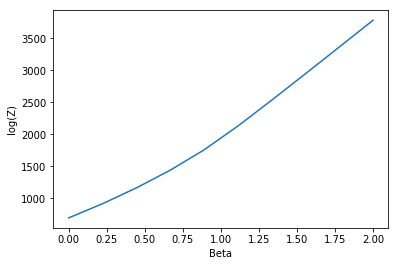

In [4]:
def comb(n):
    lst = list(map(list, itertools.product([0, 1], repeat=n)))
    return(lst)
def Ising_to_chain(height,width,alpha,beta):
        x = np.array([0., 1.])
        psi_alpha = alpha * x # shape (2,)
        psi_beta = beta * ((x== x[:, None]))

        combs = comb(width)
        psi = np.zeros((2,)*width)
        psi_edges=np.zeros((2,)*width*2)
        for c in combs:
            i=tuple(c)
            psi[i]=np.sum([psi_alpha[j] for j in i])+np.sum([psi_beta[i[j], i[j+1]] for j in range(len(i)-1)])
        combs_edges=comb(2*width)
        
        for c in combs_edges:
            i=tuple(c)
            x_i=i[:width]
            x_j=i[width:]
            psi_edges[i]=0
            for j in range(width):
                psi_edges[i]+=psi_beta[x_i[j],x_j[j]]
        psi=psi.reshape(2**width)
        psi_edges=psi_edges.reshape(2**width,2**width)
        chain_model=undirected_chain([psi for i in range(height)],[psi_edges for i in range(height)])
        return chain_model


width = 10
height = 100
alpha = 0.

betas= np.linspace(0., 2, 10)
log_Z= np.zeros(10)

for i, beta in enumerate(betas):
    chain =Ising_to_chain(height,width,alpha,beta)
    log_Z[i] = chain.compute_Z()



plt.figure()
plt.plot(betas,log_Z)
plt.xlabel("Beta")
plt.ylabel("log(Z)")

plt.show()